## Step - 1 Gather Data

In [7]:
import os
import tarfile
import urllib.request as urlreq

def extract_file(file_name):
    tar = tarfile.open(file_name, "r:gz")
    tar.extractall()
    tar.close()

url = 'http://www.cs.princeton.edu/~blei/lda-c/ap.tgz'
file_name = 'ap.tgz'

if file_name not in os.listdir():
    data = urlreq.urlretrieve(url, 'ap.tgz')
extract_file(file_name)    

#urlreq.urlretrieve?

## Step - 2 Parse and clean Data

In [1]:
text_data = []
with open('ap/ap.txt', 'r') as input_data:
    if not input_data:
        print("Failed to open file")
    for line in input_data:
        #print(line)
        if '<TEXT>' in line:
            text_data.append(input_data.readline())
            
            

###### I got the text, now I will remove all stop words, How about using nltk module 
###### We all know threading module in not going to help here for CPU-bound job like this here.
###### So lets use multiprocessing, to take advantage of available cores.


In [2]:
import nltk
from multiprocessing import Pool
from itertools import chain
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import wordpunct_tokenize

punkt = nltk.data.load('ap/vocab.txt')

porter = PorterStemmer()
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')',
                   '[', ']', '{', '}', ".''", "-", "``", ",'", ",''", ".'"]) # remove it if you need punctuation 


def tokenize_clean_text(text_data):
    '''returns tokenized and stemmed for each string in text_data
    @parmain text_data - list of string
    @paramout text_data_clean - list of string
    '''
    text_data_clean = []
    for text in text_data:
        list_of_words = ' '.join([porter.stem(i.lower()) for i in wordpunct_tokenize(text) 
                         if i.lower() not in stop_words])
        text_data_clean.append(str(list_of_words))
    return text_data_clean



In [3]:
text_data_clean = tokenize_clean_text(text_data)
text_data_clean[2]

'gunman took 74 year old woman hostag foil attempt steal $ 1 million jewelri belong late liberac polic shot kill man outsid entertain museum tri stay cool said hostag margaret bloomberg sat give polic clear shot man escap unharm sunday even incid liberac museum man bag tool includ crowbar go smash jewelri case said dora liberac administr museum sister law late entertain want jewelri came prepar take mr bloomberg work museum 10 year close offic man appear say want deliv plant mr liberac said man produc gun forc way insid refus offer money mr bloomberg said margaret offer day receipt even offer money purs interest mr liberac said said ` want cash want jewelri obvious check place seem know everyth mr bloomberg abl warn clean woman slip back door call polic gunman tie mr bloomberg hand feet tape mouth unti move anoth part museum tie get readi pop jewelri case heard nois outsid mr bloomberg said went saw polic told get back door tri polic gunman walk front door gun point bound hostag told p

## Step - 3: Feature data
Using CountVectorizer and TfidfVectorizer to featurize the text

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=.95, min_df=3, max_features=2000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(text_data_clean)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_df=.95, min_df=3, max_features=2000, stop_words='english')
tf = count_vectorizer.fit_transform(text_data_clean)


## Step - 4: Select the Model(Estimator)
Using NMF and LDA both and compare the results which works better for this data

###### NMF (Non-negative Matrix Factorization )

In [15]:
import time
from sklearn.decomposition import NMF

print("Fiting NMF with tfidf fatures ... ")
start = time.time()
nmf = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5)
nmf = nmf.fit(tfidf)

print("Took %f time to train NMF" % (time.time()-start))

Fiting NMF with tfidf fatures ... 
Took 0.656359 time to train NMF


###### LDA Latent Dirichlet Allocation

In [26]:
from sklearn.decomposition import LatentDirichletAllocation

print("Fitting LDA with tf(term frequency) features ...")
start = time.time()

lda = LatentDirichletAllocation(n_topics=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=1
                               )
lda.fit(tfidf)
print('Took %f time to train lda' % (time.time()-start))

Fitting LDA with tf(term frequency) features ...
Took 2.265766 time to train lda


In [19]:

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, 20)

Topic #0:
said year state court 000 new say compani time peopl offici work million use day hous case feder school charg
Topic #1:
soviet gorbachev union moscow summit mikhail reagan tass said republ treati missil presid germani meet leader lithuania offici news nuclear
Topic #2:
percent billion rate million sale increas year price month quarter tax product report rose inflat economist compani rise economi 1989
Topic #3:
bush dukaki democrat campaign republican jackson presid presidenti vote convent senat reagan candid poll primari tax bentsen georg governor budget
Topic #4:
stock index market share exchang trade point volum dow averag nyse unchang rose price million jone 30 composit list issu
Topic #5:
dollar yen late gold bid london ounc price dealer trade rate troy bank franc close german tokyo currenc market trader
Topic #6:
iraq iraqi kuwait saudi iran saddam gulf oil troop unit arabia arab militari forc baghdad war said bush israel foreign
Topic #7:
cent lower soybean oil bushel f

In [27]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, 20)

Topic #0:
said ms judg resid crash counti 000 book affect school court bar jail cross publish town releas file question robert
Topic #1:
soviet said student union boy gorbachev award school state year trade peopl polic farmer hospit economi new countri bank offici
Topic #2:
said year percent state million new peopl polic govern report soviet presid 000 offici bush nation say compani time stock
Topic #3:
said parti shamir soviet gorbachev rebel congress govern communist state session israel china 000 polic union right war report peopl
Topic #4:
said philippin new children wind ship columbia mph hit state wast list art island artist park coast stori cross wednesday
Topic #5:
guerrilla said brief anim medic grain collect record forest group war west offic soviet south independ research drug ms europ
Topic #6:
cent said contra monday suprem pictur court thursday sandinista bushel stock action offici nicaragua space compani ticket soybean eastern 29
Topic #7:
said bush polic rate quayl play

In [62]:
#text_data_clean
from wordcloud import WordCloud
wordcloud = WordCloud().generate(' '.join(text_data_clean))

In [57]:
wordcloud

(-0.5, 399.5, 199.5, -0.5)

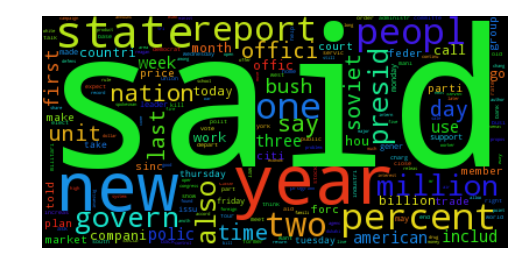

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")